In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fsolve
import numpy as np

In [2]:
class A_dist():
    def __init__(self, Beta):
        self.beta = Beta
        self.df = pd.DataFrame(columns = ['beta_hat', 'sample_size', 'initial_guess'])
        self.result = pd.DataFrame()
    
    def pdf(self, x):
        if(x <= 0): return 0
            
        c = self.beta/x
        if(c > 10): return 0
        pdf = (x**-2) * np.exp(((1 - np.exp(c))/self.beta) + c)
        return pdf

        
    def cdf(self, x):
        if(x <= 0): return 0

        c = self.beta/x
        if(c > 10): return 0
        # cdf = np.exp((1 - np.exp(c))/self.beta)
        log_cdf = (1 - np.exp(c))/(self.beta)
        return np.exp(log_cdf)

        
    def plot(self):
        fig, axs = plt.subplots(1, 2, figsize=(15,7))
        tolerance = 10**-2

        ax = axs[0]

        x = np.linspace(10**-5, 30, 1000)     
        ax.plot(x, [self.pdf(value) for value in x])
        ax.set_title('PDF')
        
        ax = axs[1]
        lim_sup = 1
        while((1 - self.cdf(lim_sup)) > tolerance): lim_sup+=1
    
        x = np.linspace(10**-5, lim_sup, 1000)     
        ax.plot(x, [self.cdf(value) for value in x])
        ax.set_title('CDF')
        plt.show()
        
    
    def MLE(self, x_values, **kwargs):
    
        initial_guess = kwargs['initial_guess']
        def estimator(beta):
            sum_X = sum(x**-1 for x in x_values)
            sum_numerator = sum(((beta/x) * np.exp(beta/x)) - np.exp(beta/x) + 1 for x in x_values)
            return sum_X - sum_numerator / (beta**2)
    
        result = fsolve(func=estimator, x0=initial_guess)
        return result[0]
    
    def exp_sample(self, n = 10):
        x = []
        for i in range(n):
            u = np.random.random()
            value = self.beta/np.log(1 - (self.beta* np.log(u)))
            while(value > 100):
                u = np.random.random()
                value = self.beta/np.log(1 - (self.beta* np.log(u)))
            x.append(value)
        return x

    def plot_sample(self, n = 10, lim_sup = 100, **kwargs):
        sample = self.exp_sample(n = n)
        fig, ax = plt.subplots(1, 1, figsize=(15,7))
        
        plt.hist(sample, bins = int(n/2), density=True, alpha=0.5, color='blue', label='Generated Data')
        # lim_sup = max(sample)

        x = np.linspace(0, lim_sup, 1000)
        pdf = [self.pdf(value) for value in x]
        
        plt.plot(x, pdf, color='red', label='Theoretical PDF')
        
        ax.set_xlim(0,100)
        plt.xlabel('Random Variable')
        plt.ylabel('Probability Density')
        plt.title('Random Variables using Inverse Transformation')
        plt.legend()
        plt.grid(True)
        
        plt.show()
        
        beta_hat = self.MLE(x_values = sample, **kwargs)
        print(f"Valor estimado para beta:{beta_hat:.2f}")
        
        return sample

    def run_experiment(self, n_rep : int, sample_sizes : list, initial_guess : list, applyGap = True):
        
        for sample_size in sample_sizes:
            for guess in initial_guess:
                for rep in range(n_rep):
                    sample = self.exp_sample(n = sample_size)
                    beta_hat = self.MLE(x_values = sample, initial_guess = guess)

                    self.df.loc[len(self.df)] = [beta_hat, sample_size, guess]
                    # print(beta_hat)
                    
        self.result = self.df.groupby(['sample_size', 'initial_guess'])['beta_hat'].agg(['mean', 'std']).reset_index()
        
        
        fig, axs = plt.subplots(1, 2, figsize = (15,7))
        
        ax = axs[1]
        for i, guess in enumerate(self.result['initial_guess'].unique()):
            data = self.result.loc[self.result['initial_guess'] == guess]     
            plt.errorbar(data['sample_size'] + i*(5 if applyGap else 0), data['mean'], yerr=data['std'], fmt='-o', capsize=5, label = guess)
        
        ax.legend()
        ax.set_title(f"Estimation of the Beta parameter - True value = {self.beta}")
        ax.set_xlabel('Sample Size')
        ax.set_ylabel('Beta_hat')
        
        ax = axs[0]
        ax = fig.add_subplot(121, projection='3d')
        for i, guess in enumerate(self.result['initial_guess'].unique()):
            data = self.result.loc[self.result['initial_guess'] == guess]
            ax.plot(data['sample_size'], [guess] * len(data), data['mean'], label=f'Initial Guess {guess}', marker='o')

        ax.set_xlabel('Sample Size')
        ax.set_ylabel('Initial Guess')
        ax.set_zlabel('Beta_hat')
        ax.legend()

        # ax.set_title(f"Estimation of the Beta parameter - True value = {self.beta}")
        ax.set_title("TEM QUE TIRAR A CAIXA AO REDOR DO PLOT!")
        plt.tight_layout()
        plt.show()

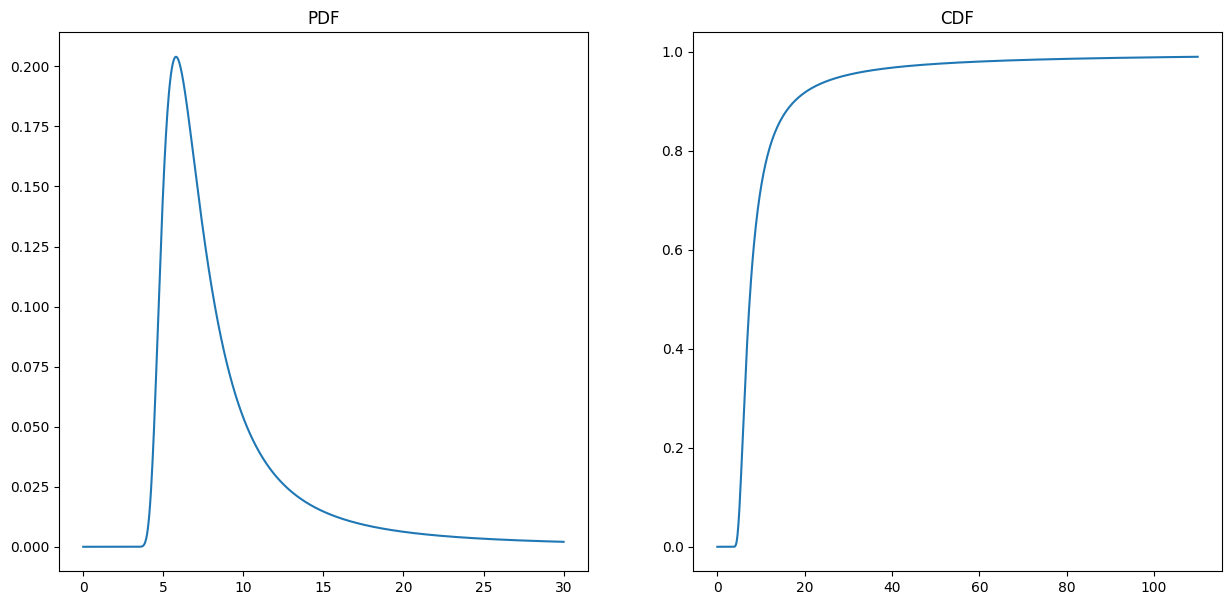

In [3]:
a = A_dist(20)
a.plot()
# a.MLE()

C:\Users\arthu\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


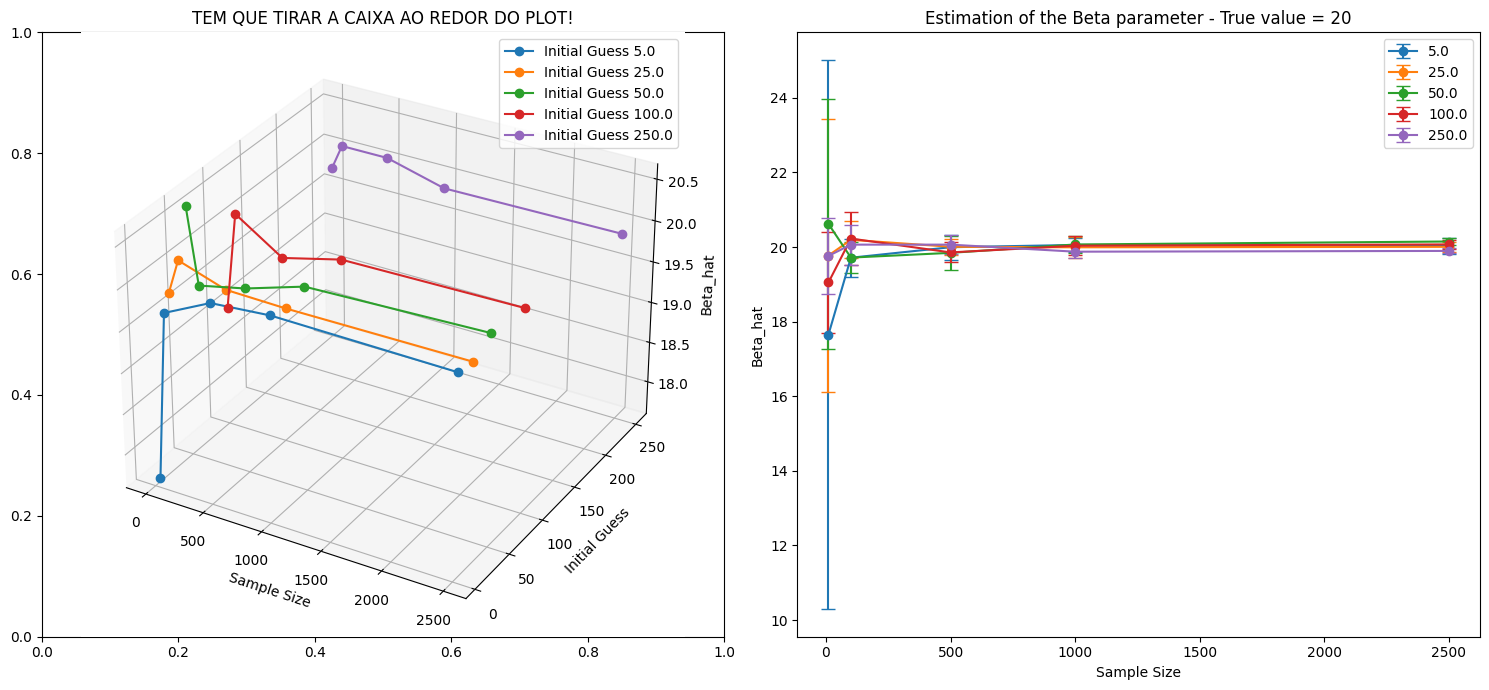

In [4]:

a.run_experiment(n_rep=5, sample_sizes = [10, 100, 500, 1000, 2500], initial_guess=[5, 25, 50, 100, 250], applyGap = False)

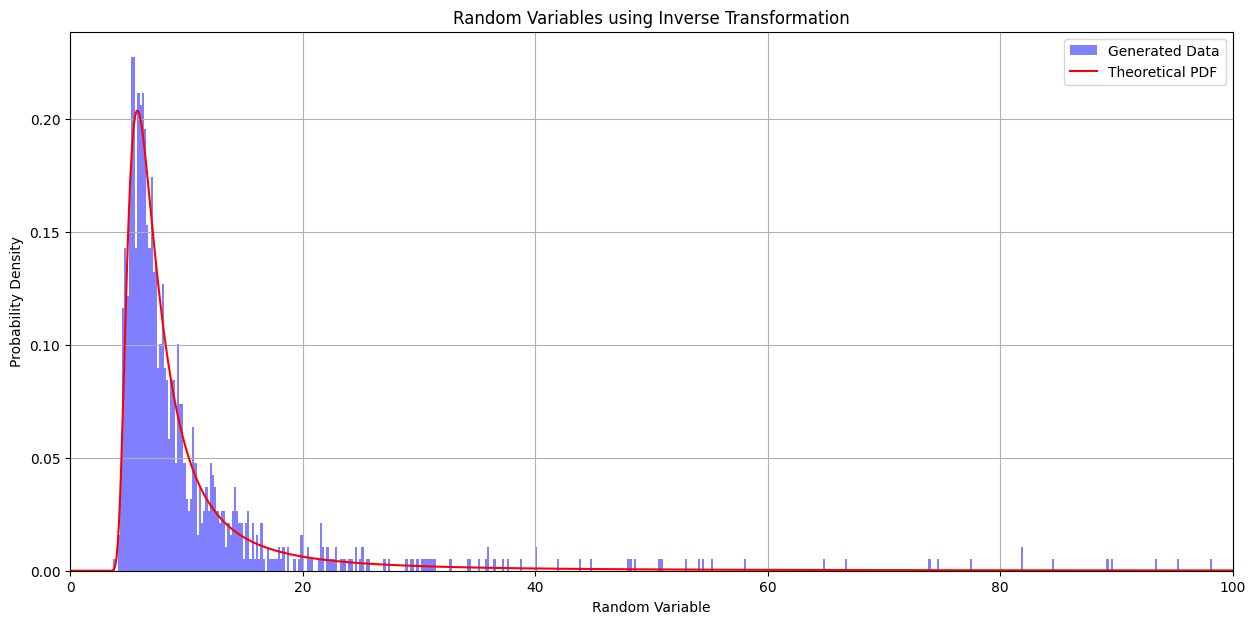

Valor estimado para beta:19.68


(1000, 98.2279059011598)

In [5]:
x = a.plot_sample(n=1000, lim_sup=100, initial_guess = 100)
len(x), max(x)

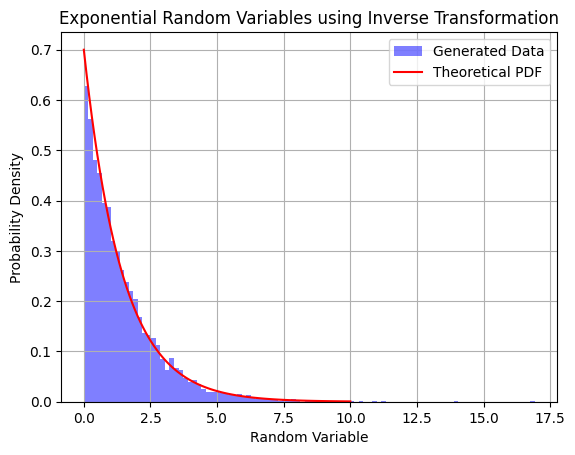

In [6]:
def exponencial_sample(alpha, n = 10):
    x = []
    for i in range(n):
        u = np.random.random()
        x.append(-np.log(1-u)/alpha)

    return x

n = 500
alpha = .7


sample = exponencial_sample(alpha = alpha, n = 5000)
plt.hist(sample, bins = 100, density=True, alpha=0.5, color='blue', label='Generated Data')

x = np.linspace(0, 10, 100)
pdf = alpha * np.exp(-alpha * x)

plt.plot(x, pdf, color='red', label='Theoretical PDF')
plt.xlabel('Random Variable')
plt.ylabel('Probability Density')
plt.title('Exponential Random Variables using Inverse Transformation')
plt.legend()
plt.grid(True)

plt.show()
